# **0. Basics**
Importing required modules and Defining some useful functions.

In [1]:
# For plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.animation as animation
from IPython.display import HTML

# For utilities
import os, shutil, time, sys

# For conversion
sys.path.insert(0, '../../')
import opencv_transforms.transforms as TF
import opencv_transforms.functional as FF
import dataloader
from PIL import Image
import cv2
import numbers

# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils
import random
from torch.autograd import Variable

# For our model
import mymodels
import torchvision.models
from torchvision import datasets, transforms

# To ignore warning
import warnings
warnings.simplefilter("ignore", UserWarning)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

if torch.cuda.is_available():
    print("The gpu to be used : {}".format(torch.cuda.get_device_name(0)))
else:
    print("No gpu detected")

The gpu to be used : GeForce GTX 1060 6GB


# **1. Loading dataset**

## 1.1 Dataloader

The code of dataloader to load input videos is written in `dataloader.py`. Loaded data is 5D tensor with size of **[N, C, L, W, H]**.

To pre-process input data, the module `opencv_transforms.transforms` and `opencv_transforms.functional` are imported. These are implemented with **openCV** so faster than `torchvision.transforms` which is based on **Pillow**.[2]

[2] Jim Bohnslav,"opencv_transforms",https://github.com/jbohnslav/opencv_transforms,2020.1.13.

In [2]:
# batch_size
batch_size=4
clip_length=16
sampling_rate=4

# Training
print('Loading Training data...', end=' ')
train_transforms = TF.Compose([
    TF.Resize((121, 178))
    ])
train_imagefolder = dataloader.VideoFolder(
    '../../dataset/aps_cut/train', 
    transform=train_transforms, 
    extensions=('avi'), 
    clip_length=clip_length,
    sampling_rate=sampling_rate,
    start_random=True,
    )
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=batch_size, shuffle=True)
train_batch = next(iter(train_loader))
print("Done!")
print("Training data size : {}".format(len(train_imagefolder)))

# Validation
print('Loading Validation data...', end=' ')
val_transforms = TF.Compose([
    TF.Resize((121, 178)),
    ])
val_imagefolder = dataloader.VideoFolder(
    '../../dataset/aps_cut/val', 
    transform=val_transforms, 
    extensions=('avi'), 
    clip_length=clip_length,
    sampling_rate=sampling_rate,
    start_random=False,
    )
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=batch_size, shuffle=False)
val_batch = next(iter(val_loader))
print("Done!")
print("Validation data size : {}".format(len(val_imagefolder)))

Loading Training data... Done!
Training data size : 2543
Loading Validation data... Done!
Validation data size : 679


## 1.2 Dataset Test

Check the dataset.

In [4]:
temp_batch_iter = iter(val_loader)

In [4]:
temp_batch = next(temp_batch_iter)
clip_list = temp_batch[0]
label = temp_batch[1]
print('Playing video... (# of clips: {0})'.format(nclip))   
print(label)
print(len(clip_list))
for clip in clip_list:
    dataloader.play_video(clip[0])
print('Finished')

NameError: name 'temp_batch_iter' is not defined

# **2. Construct the Model**

All models are implemented on `mymodels.py`.

In [3]:
net = mymodels.Classifier7().to(device) 
num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Number of parameters: %d' % (num_params))
print(net)

torch.backends.cudnn.benchmark = True

Number of parameters: 11924440
Classifier7(
  (dilation): DilationBlock(
    (convlist): ModuleList(
      (0): Sequential(
        (0): Conv3DWS(3, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), bias=False)
        (1): GroupNorm(16, 64, eps=1e-05, affine=True)
        (2): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv3DWS(3, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), dilation=(3, 1, 1), bias=False)
        (1): GroupNorm(16, 64, eps=1e-05, affine=True)
        (2): ReLU(inplace=True)
      )
      (2): Sequential(
        (0): Conv3DWS(3, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), dilation=(5, 1, 1), bias=False)
        (1): GroupNorm(16, 64, eps=1e-05, affine=True)
        (2): ReLU(inplace=True)
      )
    )
  )
  (norm1): GroupNorm(16, 64, eps=1e-05, affine=True)
  (pool1): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv3DWS(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=

# **4. Save / Load the model**

## 4.2 Load the model

In [16]:
def load(path):
    print('Loading...', end=' ')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/'+path)
    #net.load_state_dict(checkpoint['net'], strict=True)
    loss_list = checkpoint['val_loss_list']
    accr_list = checkpoint['val_accr_list']
    print("Done!")
    
    return loss_list, accr_list

In [7]:
model1_loss = []
model2_loss = []
model3_loss = []
model1_accr = []
model2_accr = []
model3_accr = []

In [22]:
model1_loss, model1_accr = load('model2.pth')
model2_loss, model2_accr = load('model6.pth')
model3_loss, model3_accr = load('model7.pth')
#model4_loss, model4_accr = load('ckpt.pth')

Loading... Done!
Loading... Done!
Loading... Done!


## 5.1 Test an image


# **5. Show the results**

## **5.1 Plot the result**

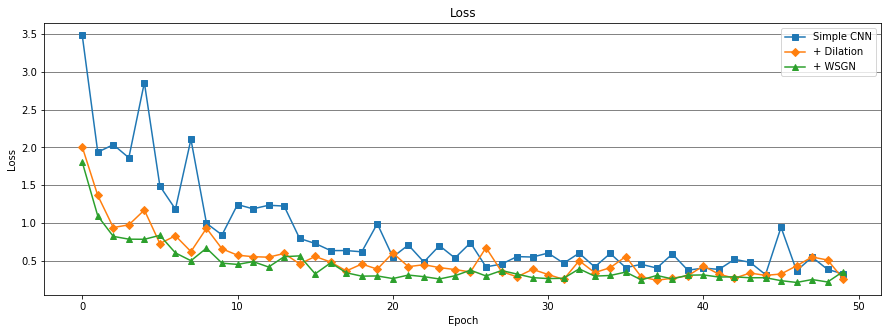

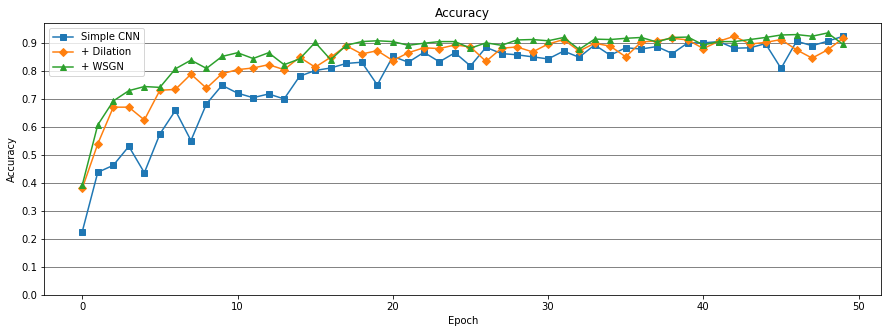

Model 1: 0.31, 92.3%
Model 2: 0.24, 92.3%
Model 3: 0.21, 93.5%


In [24]:
plt.figure(figsize=(15,5))
plt.title("Loss")
plt.plot(model1_loss, marker='s', label='Simple CNN')
plt.plot(model2_loss, marker='D', label='+ Dilation')
plt.plot(model3_loss, marker='^', label='+ WSGN')
#plt.plot(model4_loss, marker='o', label='WSGN')
plt.grid(b=True, which='major', axis='y', color='#666666', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(15,5))
plt.title("Accuracy")
plt.plot(model1_accr, marker='s', label='Simple CNN')
plt.plot(model2_accr, marker='D', label='+ Dilation')
plt.plot(model3_accr, marker='^', label='+ WSGN')
#plt.plot(model4_accr, marker='o', label='Model4')
plt.yticks(np.arange(0, 1, 0.1))
plt.grid(b=True, which='major', axis='y', color='#666666', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

print("Model 1: {0:0.2f}, {1:0.1f}%".format(min(model1_loss), max(model1_accr)*100))
print("Model 2: {0:0.2f}, {1:0.1f}%".format(min(model2_loss), max(model2_accr)*100))
print("Model 3: {0:0.2f}, {1:0.1f}%".format(min(model3_loss), max(model3_accr)*100))
#print("Model 4: {0:0.2f}, {1:0.1f}%".format(min(model4_loss), max(model4_accr)*100))